In [1]:
import os
import pickle
import string
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import keras
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
%matplotlib inline

In [2]:
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available, and TensorFlow will use it.")
else:
    print("No GPU is available, TensorFlow will use CPU.")

GPU is available, and TensorFlow will use it.


In [3]:
def extract_features(directory):
  model = VGG16()
  model.layers.pop()
  model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
  print(model.summary())
  features = {}
  for name in os.listdir(directory):
    img = load_img(directory+'/'+name,target_size=(224,224))
    img = img_to_array(img)
    img = img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
    img = preprocess_input(img)
    feature = model.predict(img,verbose=0)
    img_id = name.split('.')[0]
    features[img_id] = feature
  return features

directory ='C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/flickr30k_images'
features = extract_features(directory)
pickle.dump(features,open('C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/Flicker30k_dataset_image_features.pkl','wb'))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
def clean_and_format_descriptions(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    formatted_lines = []
    for line in lines:
        # Remove leading and trailing whitespace, and double quotes if present
        line = line.strip().strip('"')
        # Replace any space after '#' with no space
        line = line.replace('# ', '#')
        formatted_lines.append(line)

    with open(output_file, 'w', encoding='utf-8') as file:
        file.write('\n'.join(formatted_lines))

input_filename = 'C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/captions.txt'  # Replace with your input file path
output_filename = 'C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/final_captions.txt'  # Replace with your desired output file path

clean_and_format_descriptions(input_filename, output_filename)

In [5]:
import string

def load_description(filename):
    descriptions = {}
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split(' ', 1)
            if len(parts) == 2:
                img, caption = parts
                img_id, caption_id = img.split('#')
                if img_id not in descriptions:
                    descriptions[img_id] = {}
                descriptions[img_id][caption_id] = caption
    return descriptions

def clean_description(captions):
    table = str.maketrans('', '', string.punctuation)
    for img, captions_dict in captions.items():
        for caption_id, caption in captions_dict.items():
            caption = caption.replace("-", " ")
            words = caption.split()
            words = [word.lower() for word in words]
            words = [word.translate(table) for word in words]
            words = [word for word in words if len(word) > 1]
            words = [word for word in words if word.isalpha()]
            captions[img][caption_id] = ' '.join(words)

def create_corpus(descriptions):
    vocab = set()
    for img_id, captions_dict in descriptions.items():
        for caption_id, caption in captions_dict.items():
            words = caption.split()
            vocab.update(words)
    return vocab

def save_descriptions(descriptions, filename):
    with open(filename, 'w', encoding='utf-8') as file:
        for img_id, captions_dict in descriptions.items():
            for caption_id, caption in captions_dict.items():
                line = f'{img_id}#{caption_id}\t{caption}\n'
                file.write(line)

# Load descriptions from the input text file
input_filename = 'C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/final_captions.txt'
descriptions = load_description(input_filename)

# Clean the loaded descriptions
clean_description(descriptions)

# Create a corpus and print vocabulary length
vocabulary = create_corpus(descriptions)
print('Descriptions loaded:', len(descriptions))
print('Vocabulary length:', len(vocabulary))

# Save descriptions in the desired format to an output text file
output_filename = 'C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/descriptions.txt'
save_descriptions(descriptions, output_filename)

print('Descriptions saved in the desired format.')

Descriptions loaded: 31783
Vocabulary length: 18065
Descriptions saved in the desired format.


In [6]:
import os
import random

# Define the path to the directory containing the image files
image_directory = 'C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/flickr30k_images'

# Get a list of all image file names in the directory
image_files = os.listdir(image_directory)

# Define the split ratios
train_ratio = 0.7
test_ratio = 0.2
val_ratio = 0.1

# Calculate the number of images for each set
total_images = len(image_files)
num_train = int(total_images * train_ratio)
num_test = int(total_images * test_ratio)
num_val = total_images - num_train - num_test

# Shuffle the list of image file names
random.shuffle(image_files)

# Split the image file names into train, test, and validation sets
train_set = image_files[:num_train]
test_set = image_files[num_train:num_train + num_test]
val_set = image_files[num_train + num_test:]

# Define output file paths
train_file = 'C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/train_images.txt'
test_file = 'C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/test_images.txt'
val_file = 'C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/val_images.txt'

# Save the file names to text files for each set
with open(train_file, 'w') as f:
    for item in train_set:
        f.write("%s\n" % item)

with open(test_file, 'w') as f:
    for item in test_set:
        f.write("%s\n" % item)

with open(val_file, 'w') as f:
    for item in val_set:
        f.write("%s\n" % item)

print("Dataset split and file names saved.")

Dataset split and file names saved.


In [7]:
def load_set_of_image_ids(filename):
  file = open(filename,'r')
  lines = file.readlines()
  file.close()
  image_ids = set()
  for line in lines:
    if len(line)<1:
      continue
    image_ids.add(line.split('.')[0])
  return image_ids

def load_clean_descriptions(all_desc,train_desc_names):
  file = open(all_desc,'r')
  lines = file.readlines()
  descriptions = {}
  for line in lines:
    tokens = line.split()
    image_id,image_desc = tokens[0].split('.')[0],tokens[1:]
    if image_id in train_desc_names:
      if image_id not in descriptions:
        descriptions[image_id] = []
      desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
      descriptions[image_id].append(desc)
  return descriptions

def load_image_features(filename,dataset):
  all_features = pickle.load(open(filename,'rb'))
  features = {k:all_features[k] for k in dataset}
  return features

# load train image ids
train = 'C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/train_images.txt'
train_image_ids = load_set_of_image_ids(train)
print('Training images found: ',len(train_image_ids))

# load training descriptions
train_descriptions = load_clean_descriptions('C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/descriptions.txt',train_image_ids)
print('training descriptions loaded: ',len(train_descriptions))

# load training image features
train_features = load_image_features('C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/Flicker30k_dataset_image_features.pkl',train_image_ids)
print('training features loaded: ',len(train_features))

# Iterate through the first 5 items in train_descriptions and print their descriptions
for image_id, descriptions in list(train_descriptions.items())[:5]:
    print(f"Image ID: {image_id}")
    for desc in descriptions:
        print(desc)
    print()  # Print a blank line to separate images

Training images found:  22248
training descriptions loaded:  22248
training features loaded:  22248
Image ID: 1000092795
startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq
startseq two young white males are outside near many bushes endseq
startseq two men in green shirts are standing in yard endseq
startseq man in blue shirt standing in garden endseq
startseq two friends enjoy time spent together endseq

Image ID: 10002456
startseq several men in hard hats are operating giant pulley system endseq
startseq workers look down from up above on piece of equipment endseq
startseq two men working on machine wearing hard hats endseq
startseq four men on top of tall structure endseq
startseq three men on large rig endseq

Image ID: 1000268201
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq little girl in pink dress going into wooden cabin endseq
startseq little girl climbing the stairs to her playhouse ends

In [8]:
def to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def tokenization(descriptions):
  # list of all the descriptions
  all_desc_list = to_list(descriptions)  
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(all_desc_list)
  return tokenizer

# create tokenizer
tokenizer = tokenization(train_descriptions)

# word index is the dictionary /mappings of word-->integer
vocab_size = len(tokenizer.word_index)+1
print('Vocab size: ',vocab_size)

def max_length(descriptions):
  all_desc_list = to_list(descriptions)
  return (max(len(x.split()) for x in all_desc_list))


def create_sequences(tokenizer,desc_list,max_len,photo):
  X1,X2,y = [],[],[]
  # X1 will contain photo
  # X2 will contain current sequence
  # y will contain one hot encoded next word

  for desc in desc_list:
    # tokenize descriptions
    seq = tokenizer.texts_to_sequences([desc])[0]
    for i in range(1,len(seq)):
      # out seq is basically the next word in the sentence
      in_seq,out_seq = seq[:i],seq[i]
      # pad input sequence
      in_seq = pad_sequences([in_seq],maxlen=max_len)[0]
      # one hot encode output sequence
      out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
      X1.append(photo)
      X2.append(in_seq)
      y.append(out_seq)
  return np.array(X1),np.array(X2),np.array(y)

# maximum length that a description can have OR the biggest description we are having
max_len = max_length(train_descriptions)
print(max_len)

Vocab size:  15837
74


In [9]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_len))
a.shape, b.shape, c.shape
#((52, 1000), (52, 74), (52, 15758))

((52, 1000), (52, 74), (52, 15837))

In [10]:
def define_model(vocab_size, max_length):
    keras.backend.clear_session()
    inputs1 = Input(shape=(1000,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation = 'relu')(fe1)
    
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer = 'adam')
    
    print(model.summary())
    return model

In [11]:
# train our model
print('Dataset: ', len(train_image_ids))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_len)

model = define_model(vocab_size, max_len)
print(model,'model')
epochs = 10
steps = len(train_descriptions)
    
all_history = []  # Initialize a list to store history of each epoch

for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_len)
    history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    all_history.append(history.history)  # Append the history of the current epoch
    model.save('C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/models/model_'+str(i)+'.h5')

Dataset:  22248
Descriptions: train= 22248
Photos: train= 22248
Vocabulary Size: 15837
Description Length:  74
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 74, 256)      4054272     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1000)         0           ['input_1[0][0]']

In [12]:
def aggregate_history(all_history):
    aggregate = {'loss': []}
    for history in all_history:
        for key in history.keys():
            if key in aggregate:
                aggregate[key].extend(history[key])
            else:
                aggregate[key] = history[key]
    return aggregate

aggregated_history = aggregate_history(all_history)


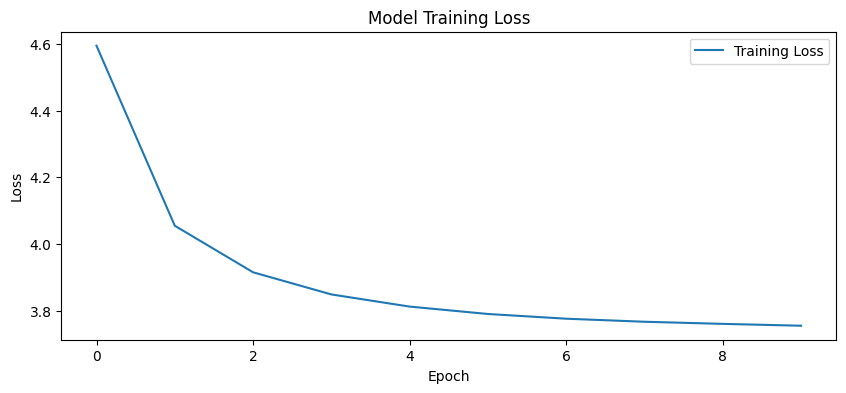

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(aggregated_history['loss'], label='Training Loss')
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [14]:
def int2word(tokenizer,integer):
  for word,index in tokenizer.word_index.items():
    if index==integer:
      return word
  return None

def predict_desc(model,tokenizer,photo,max_len):
  in_seq = 'startseq'
  for i in range(max_len):
    seq = tokenizer.texts_to_sequences([in_seq])[0]
    seq = pad_sequences([seq],maxlen=max_len)
    y_hat = model.predict([photo,seq],verbose=0)
    y_hat = np.argmax(y_hat)
    word = int2word(tokenizer,y_hat)
    if word==None:
      break
    in_seq = in_seq+' '+word
    if word=='endseq':
      break
  return in_seq

def evaluate_model(model,descriptions,photos,tokenizer,max_len):
  actual,predicted = [],[]
  for key,desc in descriptions.items():
    y_hat = predict_desc(model,tokenizer,photos[key],max_len)
    references = [d.split() for d in desc]
    actual.append(references)
    predicted.append(y_hat.split())
  print('BLEU-1: %f' %corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
  print('BLEU-2: %f' %corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))
  print('BLEU-3: %f' %corpus_bleu(actual,predicted,weights=(0.33,0.33,0.33,0)))
  print('BLEU-4: %f' %corpus_bleu(actual,predicted,weights=(0.25,0.25,0.25,0.25)))

In [15]:

####################  load training data (6k)  ##########################
train = 'C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/train_images.txt'
train_image_ids = load_set_of_image_ids(train)
print('Training images found: ',len(train_image_ids))

# load training descriptions
train_descriptions = load_clean_descriptions('C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/descriptions.txt',train_image_ids)
print('training descriptions loaded: ',len(train_descriptions))

tokenizer = tokenization(train_descriptions)
max_len = 74

####################  load test data  ##########################
test = 'C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/test_images.txt'
test_image_ids = load_set_of_image_ids(test)
print('Test images found: ',len(test_image_ids))

# load test descriptions
test_descriptions = load_clean_descriptions('C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/descriptions.txt',test_image_ids)
print('test descriptions loaded: ',len(test_descriptions))

# load test image features
test_features = load_image_features('C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/Flicker30k_dataset_image_features.pkl',test_image_ids)
print('training features loaded: ',len(test_features))
#################################################################
filename = 'C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/models/model_19.h5'
model = load_model(filename)
evaluate_model(model,test_descriptions,test_features,tokenizer,max_len)

Training images found:  22248
training descriptions loaded:  22248
Test images found:  6356
test descriptions loaded:  6356
training features loaded:  6356
BLEU-1: 0.519320
BLEU-2: 0.238611
BLEU-3: 0.126944
BLEU-4: 0.059715


In [16]:
# Validation Results

# Load validation data
val = 'C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/val_images.txt'
val_image_ids = load_set_of_image_ids(val)
print('Validation images found:', len(val_image_ids))

# Load validation descriptions
val_descriptions = load_clean_descriptions('C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/descriptions.txt', val_image_ids)
print('Validation descriptions loaded:', len(val_descriptions))

# Load validation image features
val_features = load_image_features('C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/Flicker30k_dataset_image_features.pkl', val_image_ids)
print('Validation features loaded:', len(val_features))

# Load your best model
filename = 'C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/models/model_19.h5'
model = load_model(filename)

# Evaluate the model on the validation set
evaluate_model(model, val_descriptions, val_features, tokenizer, max_len)

Validation images found: 3179
Validation descriptions loaded: 3179
Validation features loaded: 3179
BLEU-1: 0.521904
BLEU-2: 0.241047
BLEU-3: 0.126901
BLEU-4: 0.057509


In [17]:
# live testing


man in blue shirt is dog on the behind


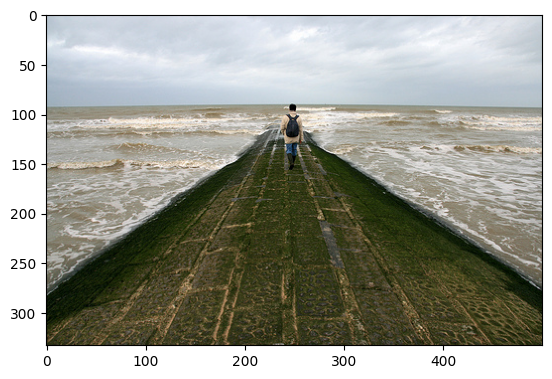

In [18]:
img_to_test = "C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/flickr30k_images/4129180972.jpg"
#C:/Users/bduser/Desktop/Capstone Project/Flickr8k/2.jpg
#C:/Users/bduser/Desktop/Capstone Project/Flickr8k_Dataset/Flicker8k_Dataset/78984436_ad96eaa802.jpg
img = plt.imread(img_to_test)
plt.imshow(img)

def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

# pre-define the max sequence length (from training)
max_length = 74
# load the model
model = load_model('C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/models/model_19.h5')
# load and prepare the photograph
photo = extract_features(img_to_test)
# generate description
description = predict_desc(model, tokenizer, photo, max_length)

description = ' '.join(description.split()[1:-1])
print()
print(description)

In [19]:
#keras tuner for hyper parameter tuning

In [20]:
import keras_tuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from keras.layers import Concatenate, Reshape

Using TensorFlow backend


C:\Users\bduser\AppData\Local\Temp\ipykernel_30264\4067984738.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [21]:
def build_model(hp):
    keras.backend.clear_session()
    
    # Define your hyperparameters
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)
    lstm_units = hp.Int('lstm_units', min_value=128, max_value=512, step=64)
    
    inputs1 = Input(shape=(1000,))
    fe1 = Dropout(dropout_rate)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(dropout_rate)(se1)
    se3 = LSTM(lstm_units)(se2)

    # Adding an additional Dense layer to reshape the output from the LSTM
    se3_reshaped = Dense(256, activation='relu')(se3)

    # Concatenate the outputs from the two branches
    merged = Concatenate()([fe2, se3_reshaped])

    decoder2 = Dense(256, activation='relu')(merged)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model


tuner = RandomSearch(
    build_model,
    objective='loss',
    max_trials=5,  # Adjust the number of trials as needed
    directory='C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/tuner/',
    project_name='my_image_captioning_tuning'
)

# You can now start the hyperparameter search
tuner.search(
    x=data_generator(train_descriptions, train_features, tokenizer, max_len),
    epochs=5,
    steps_per_epoch=steps,
    verbose=1
)

Reloading Tuner from C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/tuner/my_image_captioning_tuning\tuner0.json


In [22]:
# Get the best hyperparameters
best_hp = tuner.oracle.get_best_trials(1)[0].hyperparameters.values
print(best_hp)

{'dropout_rate': 0.30000000000000004, 'lstm_units': 320}


In [23]:
def build_model(hp):
    keras.backend.clear_session()
    
    # Define your hyperparameters
    dropout_rate = hp['dropout_rate']
    
    lstm_units = hp['lstm_units']
    
    inputs1 = Input(shape=(1000,))
    fe1 = Dropout(dropout_rate)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(dropout_rate)(se1)
    se3 = LSTM(lstm_units)(se2)

    # Adding an additional Dense layer to reshape the output from the LSTM
    se3_reshaped = Dense(256, activation='relu')(se3)

    # Concatenate the outputs from the two branches
    merged = Concatenate()([fe2, se3_reshaped])

    decoder2 = Dense(256, activation='relu')(merged)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model


# Assuming best_hp is a dictionary containing the best hyperparameters
best_hp = {'dropout_rate': 0.3, 'lstm_units': 320}

# Build the model with the best hyperparameters
best_model = build_model(best_hp)

# Train the model with the complete dataset using the best hyperparameters
best_model.fit(
    x=data_generator(train_descriptions, train_features, tokenizer, max_len),
    epochs=5,  
    steps_per_epoch=steps,
    verbose=1
)

# Save the trained model
best_model.save('C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/models/best_model.h5')

Epoch 1/5
22248/22248 [==============================] - 4727s 212ms/step - loss: 4.5925
Epoch 2/5
22248/22248 [==============================] - 4716s 212ms/step - loss: 4.0360
Epoch 3/5
22248/22248 [==============================] - 4718s 212ms/step - loss: 3.8800
Epoch 4/5
22248/22248 [==============================] - 4774s 215ms/step - loss: 3.8013
Epoch 5/5
22248/22248 [==============================] - 4733s 213ms/step - loss: 3.7559


In [24]:
def int2word(tokenizer,integer):
  for word,index in tokenizer.word_index.items():
    if index==integer:
      return word
  return None

def predict_desc(model,tokenizer,photo,max_len):
  in_seq = 'startseq'
  for i in range(max_len):
    seq = tokenizer.texts_to_sequences([in_seq])[0]
    seq = pad_sequences([seq],maxlen=max_len)
    y_hat = model.predict([photo,seq],verbose=0)
    y_hat = np.argmax(y_hat)
    word = int2word(tokenizer,y_hat)
    if word==None:
      break
    in_seq = in_seq+' '+word
    if word=='endseq':
      break
  return in_seq

def evaluate_model(model,descriptions,photos,tokenizer,max_len):
  actual,predicted = [],[]
  for key,desc in descriptions.items():
    y_hat = predict_desc(model,tokenizer,photos[key],max_len)
    references = [d.split() for d in desc]
    actual.append(references)
    predicted.append(y_hat.split())
  print('BLEU-1: %f' %corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
  print('BLEU-2: %f' %corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))
  print('BLEU-3: %f' %corpus_bleu(actual,predicted,weights=(0.33,0.33,0.33,0)))
  print('BLEU-4: %f' %corpus_bleu(actual,predicted,weights=(0.25,0.25,0.25,0.25)))

In [25]:
####################  load training data (6k)  ##########################
train = 'C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/train_images.txt'
train_image_ids = load_set_of_image_ids(train)
print('Training images found: ',len(train_image_ids))

# load training descriptions
train_descriptions = load_clean_descriptions('C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/descriptions.txt',train_image_ids)
print('training descriptions loaded: ',len(train_descriptions))

tokenizer = tokenization(train_descriptions)
max_len = 74

####################  load test data  ##########################
test = 'C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/test_images.txt'
test_image_ids = load_set_of_image_ids(test)
print('Test images found: ',len(test_image_ids))

# load test descriptions
test_descriptions = load_clean_descriptions('C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/descriptions.txt',test_image_ids)
print('test descriptions loaded: ',len(test_descriptions))

# load test image features
test_features = load_image_features('C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/Flicker30k_dataset_image_features.pkl',test_image_ids)
print('training features loaded: ',len(test_features))
#################################################################
filename = 'C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/models/best_model.h5'
model = load_model(filename)
evaluate_model(model,test_descriptions,test_features,tokenizer,max_len)

Training images found:  22248
training descriptions loaded:  22248
Test images found:  6356
test descriptions loaded:  6356
training features loaded:  6356
BLEU-1: 0.539769
BLEU-2: 0.289827
BLEU-3: 0.174591
BLEU-4: 0.098742


In [26]:
#Live Testing


man in blue shirt is walking down the beach


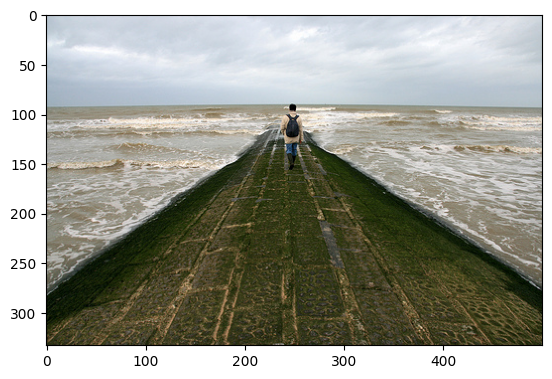

In [27]:
img_to_test = "C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/flickr30k_images/4129180972.jpg"
#C:/Users/bduser/Desktop/Capstone Project/Flickr8k/2.jpg
#C:/Users/bduser/Desktop/Capstone Project/Flickr8k_Dataset/Flicker8k_Dataset/78984436_ad96eaa802.jpg
img = plt.imread(img_to_test)
plt.imshow(img)

def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

# pre-define the max sequence length (from training)
max_length = 74
# load the model
model = load_model('C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/models/best_model.h5')
# load and prepare the photograph
photo = extract_features(img_to_test)
# generate description
description = predict_desc(model, tokenizer, photo, max_length)

description = ' '.join(description.split()[1:-1])
print()
print(description)

In [28]:
# Validation Results

# Load validation data
val = 'C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/val_images.txt'
val_image_ids = load_set_of_image_ids(val)
print('Validation images found:', len(val_image_ids))

# Load validation descriptions
val_descriptions = load_clean_descriptions('C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/descriptions.txt', val_image_ids)
print('Validation descriptions loaded:', len(val_descriptions))

# Load validation image features
val_features = load_image_features('C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/Flicker30k_dataset_image_features.pkl', val_image_ids)
print('Validation features loaded:', len(val_features))

# Load your best model
filename = 'C:/Users/bduser/Desktop/Capstone Project/flickr30k_images/models/best_model.h5'
model = load_model(filename)

# Evaluate the model on the validation set
evaluate_model(model, val_descriptions, val_features, tokenizer, max_len)

Validation images found: 3179
Validation descriptions loaded: 3179
Validation features loaded: 3179
BLEU-1: 0.540738
BLEU-2: 0.292599
BLEU-3: 0.175422
BLEU-4: 0.098934


In [31]:
#Learning curve for the best fit model

# Assuming best_hp is a dictionary containing the best hyperparameters
best_hp = {'dropout_rate': 0.3, 'lstm_units': 320}

# Build the model with the best hyperparameters
best_model = build_model(best_hp)

validation_data = data_generator(val_descriptions, val_features, tokenizer, max_len)
validation_steps = len(val_descriptions)
history = best_model.fit(
    x=data_generator(train_descriptions, train_features, tokenizer, max_len),
    epochs=5,
    steps_per_epoch=steps,
    verbose=1,
    validation_data=validation_data,
    validation_steps= validation_steps
)

Epoch 1/5
22248/22248 [==============================] - 5096s 229ms/step - loss: 4.5889 - val_loss: 4.1586
Epoch 2/5
22248/22248 [==============================] - 5075s 228ms/step - loss: 4.0284 - val_loss: 3.9925
Epoch 3/5
22248/22248 [==============================] - 5070s 228ms/step - loss: 3.8737 - val_loss: 3.9410
Epoch 4/5
22248/22248 [==============================] - 5019s 226ms/step - loss: 3.7969 - val_loss: 3.9286
Epoch 5/5
22248/22248 [==============================] - 5035s 226ms/step - loss: 3.7524 - val_loss: 3.9269
